# project star – ding/lehrer itt with causalpfn

_baseline benchmark (itt), ding & lehrer (2006), “estimating treatment effects from contaminated multi-period education experiments: the dynamic impacts of class size reductions,” table 3. pulled directly from `ding_lehrer_pdf.pdf`._

In [1]:
import os
import random
from pathlib import Path

import numpy as np
import pandas as pd
import pyreadstat
import pdfplumber
import torch
from causalpfn import ATEEstimator, CATEEstimator
import causalpfn.causal_estimator as ce
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import GradientBoostingRegressor

# keep mac runs stable
os.environ.setdefault("OMP_NUM_THREADS", "1")
os.environ.setdefault("MKL_NUM_THREADS", "1")
os.environ.setdefault("OPENBLAS_NUM_THREADS", "1")
os.environ.setdefault("VECLIB_MAXIMUM_THREADS", "1")
os.environ.setdefault("NUMEXPR_NUM_THREADS", "1")
torch.set_num_threads(1)
torch.set_num_interop_threads(1)

# paths
PROJECT_STAR_DIR = Path("/Users/richardguo/csc494-spatialpfn/economics/project_star")
DATA_PATH = PROJECT_STAR_DIR / "dataverse_files" / "STAR_Students.sav"
OUTDIR = PROJECT_STAR_DIR / "results"
OUTDIR.mkdir(parents=True, exist_ok=True)
OUT_CSV = OUTDIR / "ding_lehrer_causalpfn_notebook.csv"

# treatment setup
TREAT_COL = "gkclasstype"
TREATED_VALUES = {1.0}
CONTROL_VALUES = {2.0, 3.0}

# outcomes
GRADE_SPECS = {
    "g1": {"reading": "g1treadss", "math": "g1tmathss", "word": "g1wordskillss"},
    "g2": {"reading": "g2treadss", "math": "g2tmathss", "word": "g2wordskillss"},
    "g3": {"reading": "g3treadss", "math": "g3tmathss", "word": "g3wordskillss"},
}

# baseline covariates
COVARIATES = [
    "gender",
    "race",
    "birthyear",
    "birthmonth",
    "birthday",
    "gksurban",
    "gkfreelunch",
    "gkrepeat",
    "gkspeced",
    "gkspecin",
]

# config
DEVICE = "cpu"
TEST_FRAC = 0.2
N_SPLITS = int(os.getenv("STAR_N_SPLITS", "8"))
BASE_SEED = 2025
GRADE_SEED_OFFSET = {"g1": 11, "g2": 23, "g3": 37}
OUTCOME_SEED_OFFSET = {"reading": 1, "math": 3, "word": 5}

# store per-row preds for uplift/qini
PRED_ROWS: list[dict] = []

# patch causalpfn weak learner to avoid min_samples_leaf=0 on small n
def _safe_train_weak_learner(self, X, t, y) -> GradientBoostingRegressor:
    self.t_transformer = OneHotEncoder(sparse_output=False, categories="auto", drop="first")
    T = self.t_transformer.fit_transform(t.reshape(-1, 1))
    self._d_t = (T.shape[1],)
    feat_arr = np.concatenate((X, 1 - np.sum(T, axis=1).reshape(-1, 1), T), axis=1)
    min_leaf = max(1, int(X.shape[0] / 100))
    self.stratifier = GradientBoostingRegressor(
        n_estimators=100,
        max_depth=6,
        min_samples_leaf=min_leaf,
        random_state=111,
    )
    self.stratifier.fit(feat_arr, y)

ce.CausalEstimator._train_weak_learner = _safe_train_weak_learner


/Users/richardguo/.pyenv/versions/3.11.8/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# baseline benchmark from ding & lehrer (2006) table 3 (itt)
from pathlib import Path
import pdfplumber
import pandas as pd

# set project dir if not already defined
try:
    PROJECT_STAR_DIR
except NameError:
    PROJECT_STAR_DIR = Path("/Users/richardguo/csc494-spatialpfn/economics/project_star")

pdf_path = PROJECT_STAR_DIR / "ding_lehrer_pdf.pdf"
with pdfplumber.open(pdf_path) as pdf:
    table = pdf.pages[51].extract_tables()[0]

# table layout: row 2 has itt cells in order math g1..g3, reading g1..g3, word g1..g3
itt_cells = table[2][1:]
grades = ["grade1", "grade2", "grade3"]
outcomes = ["math", "reading", "word"]

bench_rows = []
for block_idx, outcome in enumerate(outcomes):
    for grade_idx, grade in enumerate(grades):
        cell = itt_cells[block_idx * 3 + grade_idx]
        mean_str, se_str = cell.split("\n")
        bench_rows.append(
            {
                "outcome": outcome,
                "grade": grade,
                "itt_mean": float(mean_str),
                "itt_se": float(se_str.strip("()")),
            }
        )
bench_df = pd.DataFrame(bench_rows)
bench_df

,outcome,grade,itt_mean,itt_se
0,math,grade1,9.023,1.946
1,math,grade2,5.389,2.480
2,math,grade3,4.329,2.048
3,reading,grade1,10.409,2.288
4,reading,grade2,4.698,2.316
5,reading,grade3,7.189,1.917
6,word,grade1,9.036,2.377
7,word,grade2,4.622,2.314
8,word,grade3,8.127,2.450


In [3]:
# load spss file
df_star, meta = pyreadstat.read_sav(DATA_PATH)
df_star.shape

(11601, 379)

In [4]:
# helper utils
def set_all_seeds(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


def split_idx(n: int, test_frac: float, seed: int):
    rng = np.random.default_rng(seed)
    idx = np.arange(n)
    rng.shuffle(idx)
    n_test = max(1, int(round(test_frac * n)))
    te = idx[:n_test]
    tr = idx[n_test:]
    return tr, te


def standardize_train_apply(Xtr: np.ndarray, Xte: np.ndarray, eps: float = 1e-8):
    mu = Xtr.mean(axis=0, keepdims=True)
    sd = Xtr.std(axis=0, keepdims=True)
    sd = np.where(sd < eps, 1.0, sd)
    return (Xtr - mu) / sd, (Xte - mu) / sd


def ate_diff_in_means(Y: np.ndarray, T: np.ndarray) -> float:
    t1 = (T == 1)
    t0 = (T == 0)
    if t1.sum() == 0 or t0.sum() == 0:
        return float("nan")
    return float(Y[t1].mean() - Y[t0].mean())


def build_features(df: pd.DataFrame) -> np.ndarray:
    X = df[COVARIATES].copy()
    cat_cols = [c for c in X.columns if X[c].dtype == "object" or str(X[c].dtype).startswith("category")]
    if cat_cols:
        X = pd.get_dummies(X, columns=cat_cols, drop_first=True)
    for c in X.columns:
        if X[c].isna().any():
            if np.issubdtype(X[c].dtype, np.number):
                X[c] = X[c].fillna(X[c].median())
            else:
                X[c] = X[c].fillna("MISSING")
    return X.astype(np.float32).to_numpy()


def build_treatment(df: pd.DataFrame):
    t_series = df[TREAT_COL]
    treated = t_series.isin(TREATED_VALUES)
    control = t_series.isin(CONTROL_VALUES)
    keep = (treated | control)
    t = treated.astype(float)
    return t.to_numpy().astype(np.float32), keep.to_numpy()


def run_grade_outcome(df: pd.DataFrame, grade_key: str, outcome_name: str, y_col: str) -> list[dict]:
    rows: list[dict] = []
    T_all, keep_t = build_treatment(df)
    keep_y = df[y_col].notna().to_numpy()
    keep = keep_t & keep_y
    dfk = df.loc[keep].copy().reset_index(drop=True)
    if dfk.empty:
        return rows
    T = T_all[keep]
    Y = dfk[y_col].astype(np.float32).to_numpy()
    X = build_features(dfk)
    n = X.shape[0]
    p = X.shape[1]
    n_treat = int((T == 1).sum())
    n_ctrl = int((T == 0).sum())
    for split in range(N_SPLITS):
        seed = BASE_SEED + 1000 * split + GRADE_SEED_OFFSET.get(grade_key, 0) + OUTCOME_SEED_OFFSET.get(outcome_name, 0)
        set_all_seeds(seed)
        tr_idx, te_idx = split_idx(n, TEST_FRAC, seed)
        Xtr, Xte = X[tr_idx], X[te_idx]
        Ttr, Tte = T[tr_idx], T[te_idx]
        Ytr, Yte = Y[tr_idx], Y[te_idx]
        Xtr, Xte = standardize_train_apply(Xtr, Xte)
        ate_est = ATEEstimator(device=DEVICE)
        cate_est = CATEEstimator(device=DEVICE)
        ate_est.fit(Xtr, Ttr, Ytr)
        cate_est.fit(Xtr, Ttr, Ytr)
        ate_hat = float(ate_est.estimate_ate())
        cate_hat = np.asarray(cate_est.estimate_cate(Xte), dtype=np.float32)

        # save per-row preds for uplift/qini
        for j, row_id in enumerate(te_idx):
            PRED_ROWS.append({
                'grade': grade_key,
                'outcome': outcome_name,
                'split': split,
                'row_id': int(row_id),
                'T': float(Tte[j]),
                'Y': float(Yte[j]),
                'cate_hat': float(cate_hat[j]),
            })

        diff_dm = ate_diff_in_means(Yte, Tte)
        rows.append(
            {
                "grade": grade_key,
                "outcome": outcome_name,
                "y_col": y_col,
                "split": split,
                "n_used": int(n),
                "p": int(p),
                "treated": n_treat,
                "control": n_ctrl,
                "ate_hat": ate_hat,
                "ate_method": "causalpfn_ate",
                "diff_in_means_test": diff_dm,
                "cate_mean": float(cate_hat.mean()),
                "cate_std": float(cate_hat.std()),
                "device": DEVICE,
                "seed": int(seed),
                "test_frac": float(TEST_FRAC),
            }
        )
    return rows


In [5]:
# run all grades/outcomes
all_rows: list[dict] = []
for grade_key, outcomes in GRADE_SPECS.items():
    for outcome_name, y_col in outcomes.items():
        if y_col not in df_star.columns:
            print(f"skip {grade_key}-{outcome_name}: {y_col} missing")
            continue
        print(f"running {grade_key} {outcome_name} ({y_col}) ...")
        rows = run_grade_outcome(df_star, grade_key, outcome_name, y_col)
        if not rows:
            print(f"  no data kept for {grade_key}-{outcome_name}")
        all_rows.extend(rows)

results_df = pd.DataFrame(all_rows)
results_df.to_csv(OUT_CSV, index=False)
print(f"saved splits to {OUT_CSV}")
results_df.head()

running g1 reading (g1treadss) ...
running g1 math (g1tmathss) ...
running g1 word (g1wordskillss) ...
running g2 reading (g2treadss) ...
running g2 math (g2tmathss) ...
running g2 word (g2wordskillss) ...
running g3 reading (g3treadss) ...
running g3 math (g3tmathss) ...
running g3 word (g3wordskillss) ...
saved splits to /Users/richardguo/csc494-spatialpfn/economics/project_star/results/ding_lehrer_causalpfn_notebook.csv


,grade,outcome,y_col,split,n_used,p,treated,control,ate_hat,ate_method,diff_in_means_test,cate_mean,cate_std,device,seed,test_frac
0,g1,reading,g1treadss,0,4310,10,1342,2968,8.486575,causalpfn_ate,14.414490,9.053736,5.428311,cpu,2037,0.2
1,g1,reading,g1treadss,1,4310,10,1342,2968,9.821765,causalpfn_ate,11.519348,10.768787,5.174356,cpu,3037,0.2
2,g1,reading,g1treadss,2,4310,10,1342,2968,9.533269,causalpfn_ate,10.289429,10.429273,6.429658,cpu,4037,0.2
3,g1,reading,g1treadss,3,4310,10,1342,2968,9.887442,causalpfn_ate,10.743896,10.894794,5.153070,cpu,5037,0.2
4,g1,reading,g1treadss,4,4310,10,1342,2968,9.780547,causalpfn_ate,10.087830,10.357501,5.219995,cpu,6037,0.2


In [6]:
# aggregate across splits
if len(results_df):
    agg = (
        results_df.groupby(["grade", "outcome"])
        .agg(
            n_used=("n_used", "first"),
            p=("p", "first"),
            treated=("treated", "first"),
            control=("control", "first"),
            ate_mean=("ate_hat", "mean"),
            ate_std=("ate_hat", "std"),
            diff_in_means_test=("diff_in_means_test", "mean"),
            cate_mean=("cate_mean", "mean"),
            cate_std=("cate_std", "mean"),
            splits=("split", "count"),
        )
        .reset_index()
    )
    display(agg)
else:
    print("no results produced")


,grade,outcome,n_used,p,treated,control,ate_mean,ate_std,diff_in_means_test,cate_mean,cate_std,splits
0,g1,math,4422,10,1373,3049,9.849255,0.905394,9.108238,10.271435,4.730958,8
1,g1,reading,4310,10,1342,2968,9.957384,0.957964,10.595390,10.640585,5.416136,8
2,g1,word,3795,10,1198,2597,9.836507,0.777014,9.292496,10.177681,2.988443,8
3,g2,math,3466,10,1079,2387,5.611317,0.562061,7.383408,5.385746,2.970665,8
4,g2,reading,3473,10,1084,2389,6.229586,0.932621,6.592041,5.727951,3.174969,8
5,g2,word,3499,10,1090,2409,7.434322,1.032874,5.860687,6.953982,2.936248,8
6,g3,math,3056,10,952,2104,5.418454,0.671375,4.140045,5.142812,3.112405,8
7,g3,reading,3019,10,940,2079,6.371235,1.212201,6.901077,6.030269,3.249324,8
8,g3,word,3124,10,973,2151,7.587050,0.941517,7.215294,7.200925,3.044031,8


In [7]:
# compare causalpfn vs ding/lehrer itt
if 'bench_df' in locals() and 'results_df' in locals():
    agg = (
        results_df.groupby(['grade', 'outcome'])
        .agg(ate_mean=('ate_hat', 'mean'))
        .reset_index()
    )
    agg['grade_label'] = agg['grade'].map({'g1': 'grade1', 'g2': 'grade2', 'g3': 'grade3'})
    comp = agg.merge(
        bench_df,
        left_on=['grade_label', 'outcome'],
        right_on=['grade', 'outcome'],
        how='left',
        suffixes=('_causalpfn', '_ding_lehrer'),
    )
    comp = comp[['outcome', 'grade_label', 'itt_mean', 'itt_se', 'ate_mean']]
    comp = comp.rename(columns={'grade_label': 'grade', 'itt_mean': 'itt_mean_ding_lehrer', 'itt_se': 'itt_se_ding_lehrer', 'ate_mean': 'ate_mean_causalpfn'})
    display(comp)
else:
    print('bench_df or results_df missing; run earlier cells first')


,outcome,grade,itt_mean_ding_lehrer,itt_se_ding_lehrer,ate_mean_causalpfn
0,math,grade1,9.023,1.946,9.849255
1,reading,grade1,10.409,2.288,9.957384
2,word,grade1,9.036,2.377,9.836507
3,math,grade2,5.389,2.480,5.611317
4,reading,grade2,4.698,2.316,6.229586
5,word,grade2,4.622,2.314,7.434322
6,math,grade3,4.329,2.048,5.418454
7,reading,grade3,7.189,1.917,6.371235
8,word,grade3,8.127,2.450,7.587050


/var/folders/pq/r88fynjd0cvc2y0x_qdbfnym0000gn/T/ipykernel_18373/1577828830.py:23: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  uplift_split = g.groupby(['split', 'decile']).apply(uplift_fn).reset_index(name='uplift')


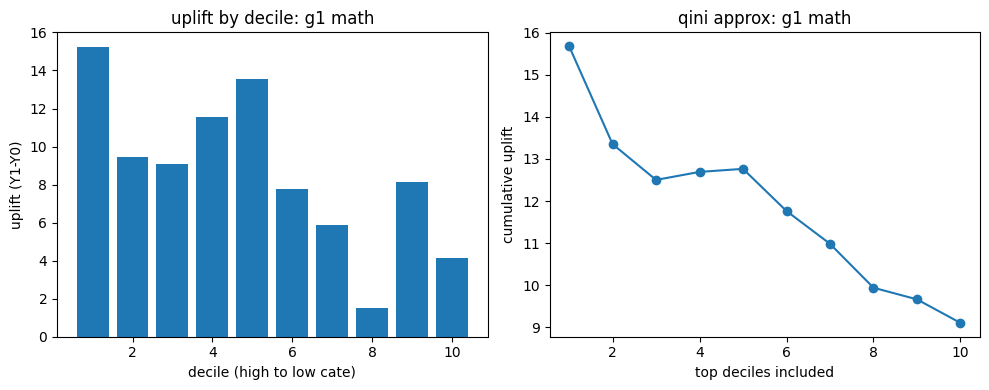

/var/folders/pq/r88fynjd0cvc2y0x_qdbfnym0000gn/T/ipykernel_18373/1577828830.py:23: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  uplift_split = g.groupby(['split', 'decile']).apply(uplift_fn).reset_index(name='uplift')


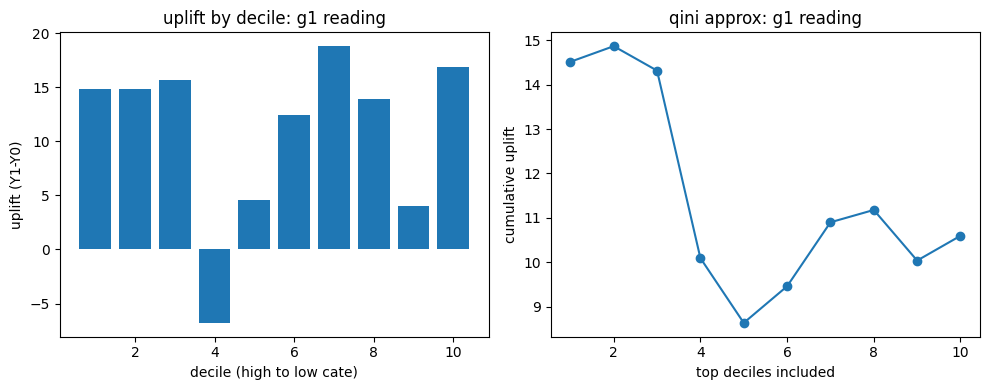

/var/folders/pq/r88fynjd0cvc2y0x_qdbfnym0000gn/T/ipykernel_18373/1577828830.py:23: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  uplift_split = g.groupby(['split', 'decile']).apply(uplift_fn).reset_index(name='uplift')


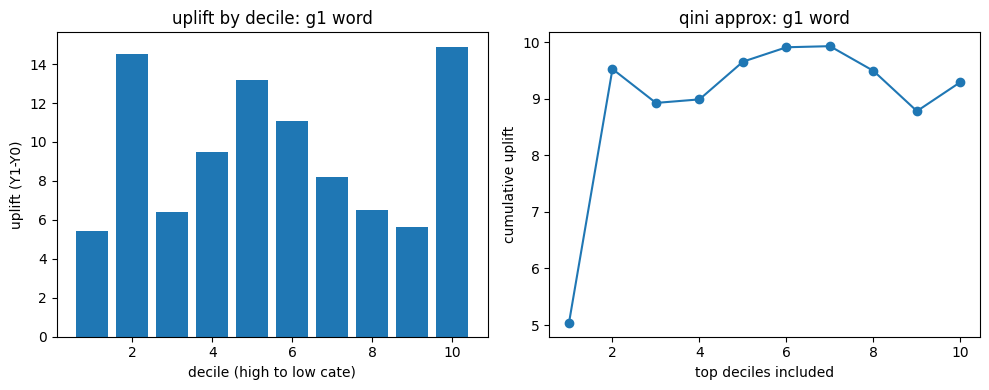

/var/folders/pq/r88fynjd0cvc2y0x_qdbfnym0000gn/T/ipykernel_18373/1577828830.py:23: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  uplift_split = g.groupby(['split', 'decile']).apply(uplift_fn).reset_index(name='uplift')


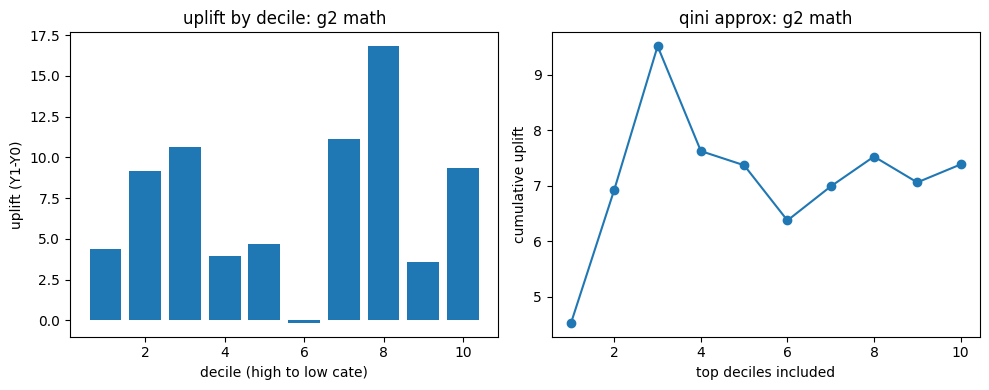

/var/folders/pq/r88fynjd0cvc2y0x_qdbfnym0000gn/T/ipykernel_18373/1577828830.py:23: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  uplift_split = g.groupby(['split', 'decile']).apply(uplift_fn).reset_index(name='uplift')


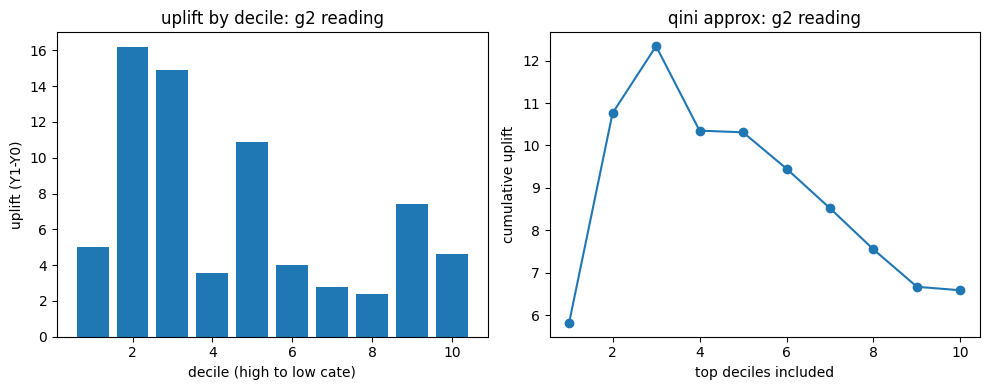

/var/folders/pq/r88fynjd0cvc2y0x_qdbfnym0000gn/T/ipykernel_18373/1577828830.py:23: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  uplift_split = g.groupby(['split', 'decile']).apply(uplift_fn).reset_index(name='uplift')


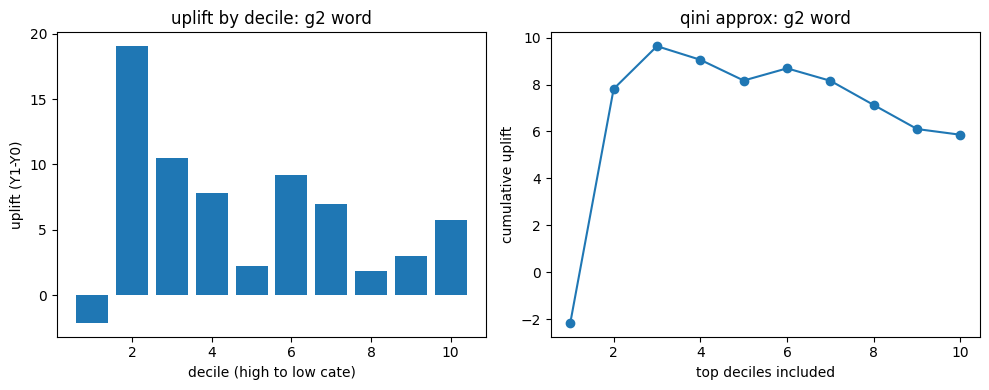

/var/folders/pq/r88fynjd0cvc2y0x_qdbfnym0000gn/T/ipykernel_18373/1577828830.py:23: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  uplift_split = g.groupby(['split', 'decile']).apply(uplift_fn).reset_index(name='uplift')


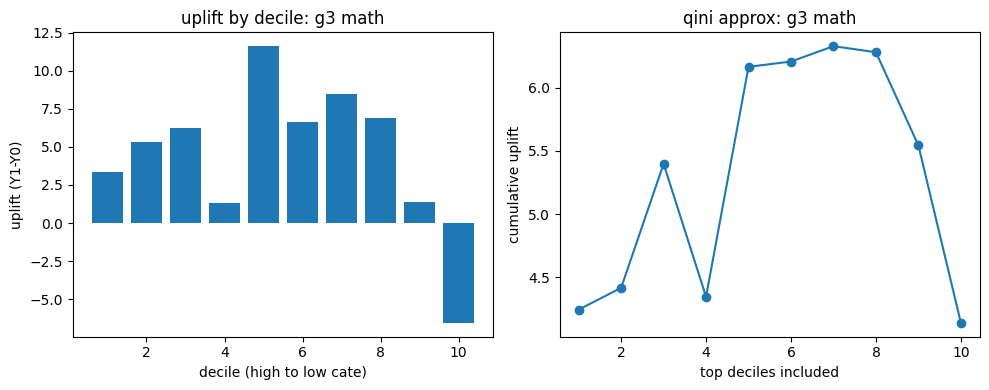

/var/folders/pq/r88fynjd0cvc2y0x_qdbfnym0000gn/T/ipykernel_18373/1577828830.py:23: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  uplift_split = g.groupby(['split', 'decile']).apply(uplift_fn).reset_index(name='uplift')


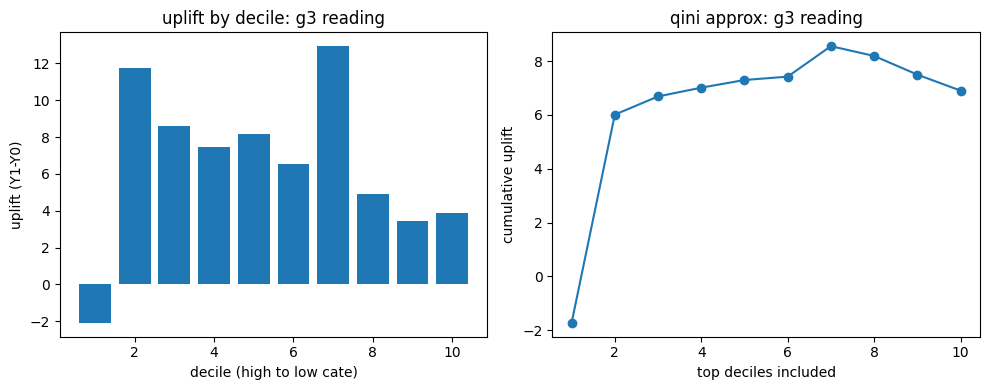

/var/folders/pq/r88fynjd0cvc2y0x_qdbfnym0000gn/T/ipykernel_18373/1577828830.py:23: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  uplift_split = g.groupby(['split', 'decile']).apply(uplift_fn).reset_index(name='uplift')


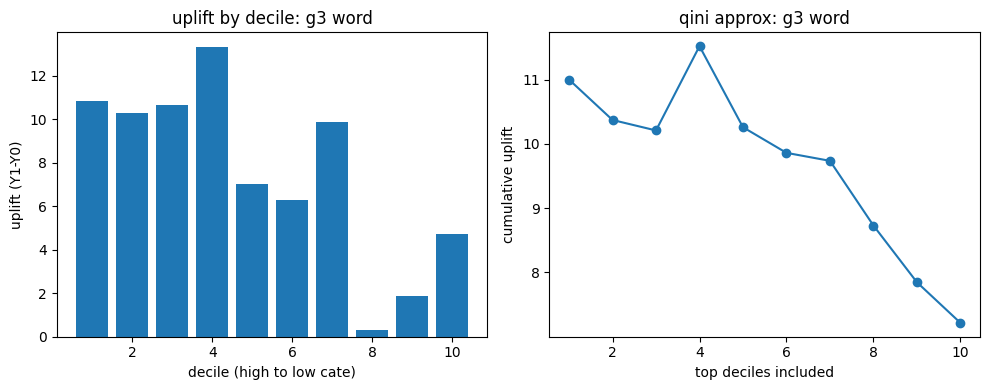

In [9]:
# uplift and qini plots
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

pred_df = pd.DataFrame(PRED_ROWS)
if pred_df.empty:
    print('no preds; run the estimation cells first')
else:
    def uplift_fn(df):
        tcol = df['T']
        ycol = df['Y']
        y1 = ycol.loc[tcol == 1].mean()
        y0 = ycol.loc[tcol == 0].mean()
        return y1 - y0

    groups = pred_df.groupby(['grade', 'outcome'])
    for (grade, outcome), g in groups:
        g = g.copy()
        g['rank_pct'] = g.groupby('split')['cate_hat'].rank(pct=True, ascending=False)
        g['decile'] = (g['rank_pct'] * 10).astype(int).clip(0, 9)

        uplift_split = g.groupby(['split', 'decile']).apply(uplift_fn).reset_index(name='uplift')
        uplift = uplift_split.groupby('decile')['uplift'].mean()

        # qini-style cumulative gain by decile (average across splits)
        gains = []
        for split, gs in g.groupby('split'):
            gs = gs.sort_values('cate_hat', ascending=False)
            n = len(gs)
            split_gains = []
            for k in range(1, 11):
                top = gs.iloc[: max(1, int(np.ceil(k * n / 10)))]
                split_gains.append(uplift_fn(top))
            gains.append(split_gains)
        gains = np.asarray(gains)
        qini_mean = np.nanmean(gains, axis=0)

        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
        axes[0].bar(range(1, 11), uplift.values)
        axes[0].set_title(f'uplift by decile: {grade} {outcome}')
        axes[0].set_xlabel('decile (high to low cate)')
        axes[0].set_ylabel('uplift (Y1-Y0)')

        axes[1].plot(range(1, 11), qini_mean, marker='o')
        axes[1].set_title(f'qini approx: {grade} {outcome}')
        axes[1].set_xlabel('top deciles included')
        axes[1].set_ylabel('cumulative uplift')
        plt.tight_layout()
        plt.show()
